Processing file: ./experiment_results\Experiment-40-strategy_bce_inverted-gemma3_opt_pairs.txt with label: strategy_bce_inverted-gemma3_opt_pairs
Processing file: ./experiment_results\Experiment-41-strategy_bce_inverted-gpt-4.1-azure_openai_opt_pairs.txt with label: strategy_bce_inverted-gpt-4.1-azure_openai_opt_pairs


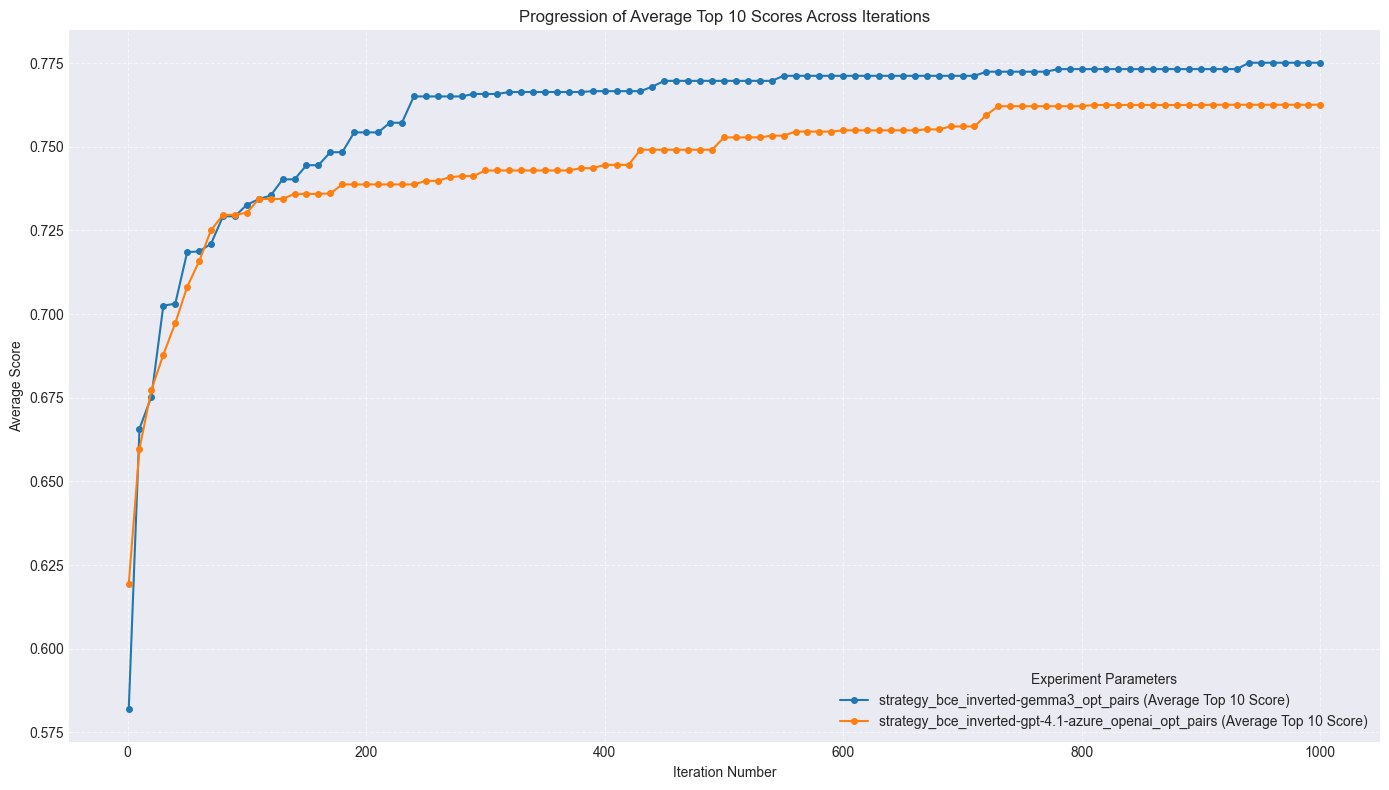

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import defaultdict

def parse_experiment_file(filepath):
    """
    Parses a single experiment file to extract scores for each iteration.
    Returns a dictionary where keys are iteration numbers and values are
    lists of (description_pair, score) tuples for that iteration.
    """
    iterations_data = defaultdict(list)
    current_iteration = None

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('Iteration'):
                try:
                    current_iteration = int(line.split(':')[0].split(' ')[1])
                except (ValueError, IndexError):
                    current_iteration = None # Reset if parsing fails
                continue
            
            if current_iteration is not None and line:
                # Regex to match the tuple format and score
                match = re.match(r"\((.+?), (.+?)\), Score: (\d+\.\d+)", line)
                if match:
                    desc1 = match.group(1).strip().strip("'")
                    desc2 = match.group(2).strip().strip("'")
                    score = float(match.group(3))
                    iterations_data[current_iteration].append(((desc1, desc2), score))
    return iterations_data

def get_top_n_scores(iteration_data, n=10):
    """
    Given data for a single iteration, returns the top N scores.
    """
    # Sort by score in descending order and take the top N
    sorted_scores = sorted(iteration_data, key=lambda x: x[1], reverse=True)
    return [score for _, score in sorted_scores[:n]]

def plot_experiment_scores(experiment_numbers, directory="./experiment_results"):
    """
    Plots the progression of top 10 scores for given experiment numbers.

    Args:
        experiment_numbers (list): A list of experiment numbers (e.g., [40, 41]).
        directory (str): The directory where the experiment files are located.
    """
    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice seaborn style
    plt.figure(figsize=(14, 8))

    all_experiment_data = {} # Stores {label: {iteration: [top_10_scores]}}

    for exp_num in experiment_numbers:
        filepath_found = None
        label = ""
        # Find the correct file based on the prefix
        for filename in os.listdir(directory):
            if filename.startswith(f"Experiment-{exp_num}-") and filename.endswith(".txt"):
                filepath_found = os.path.join(directory, filename)
                # Extract label from filename: everything after Experiment-{num}- and before .txt
                label = filename.split(f"Experiment-{exp_num}-")[1].replace(".txt", "")
                break
        
        if not filepath_found:
            print(f"Warning: File for Experiment-{exp_num} not found. Skipping.")
            continue
        
        print(f"Processing file: {filepath_found} with label: {label}")
        parsed_data = parse_experiment_file(filepath_found)
        
        experiment_scores = defaultdict(list)
        for iteration, scores_list in parsed_data.items():
            top_scores = get_top_n_scores(scores_list, n=10)
            experiment_scores[iteration].extend(top_scores) # Store all 10 top scores

        all_experiment_data[label] = experiment_scores

    if not all_experiment_data:
        print("No experiment data found to plot.")
        return

    # Prepare data for plotting
    for label, iter_data in all_experiment_data.items():
        iterations = sorted(iter_data.keys())
        
        # Calculate min, max, and average of the top 10 scores for each iteration
        min_scores = [min(iter_data[it]) for it in iterations]
        max_scores = [max(iter_data[it]) for it in iterations]
        avg_scores = [sum(iter_data[it]) / len(iter_data[it]) if iter_data[it] else 0 for it in iterations]

        # Plot min, max, and average. You can choose to plot only average for clarity.
        # plt.plot(iterations, min_scores, label=f'{label} (Min)', linestyle=':', alpha=0.7)
        # plt.plot(iterations, max_scores, label=f'{label} (Max)', linestyle='--', alpha=0.7)
        plt.plot(iterations, avg_scores, label=f'{label} (Average Top 10 Score)', marker='o', markersize=4)

    plt.title('Progression of Average Top 10 Scores Across Iterations')
    plt.xlabel('Iteration Number')
    plt.ylabel('Average Score')
    plt.legend(title='Experiment Parameters')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Main execution ---
if __name__ == "__main__":
    experiment_numbers_to_plot = [40, 41] 
    plot_experiment_scores(experiment_numbers_to_plot)